In [9]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
SRC_PATH = Path('/n/home01/egraff/sample_imputation/src')
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

from mims.mims_unit import mims_unit

DATA_ROOT = Path('/n/home01/egraff/sample_imputation/data/raw')
SUBJECT_IDS = sorted(
    d.name for d in DATA_ROOT.iterdir()
    if d.is_dir() and d.name != '__MACOSX'
)

if not SUBJECT_IDS:
    raise FileNotFoundError(f'No participant directories found in {DATA_ROOT}')

print(f'Found {len(SUBJECT_IDS)} participants: {", ".join(SUBJECT_IDS)}')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 6 participants: 3si9xdvl, bn4j8yj9, gq36edfi, ubrmuu2r, xwyd72l9, zg5uqa5l


In [10]:
def subject_csv_files(subject_id: str) -> list[Path]:
    accel_dir = DATA_ROOT / subject_id / 'accelerometer'
    if not accel_dir.exists():
        raise FileNotFoundError(f'Accelerometer directory not found for {subject_id}: {accel_dir}')

    files = sorted(accel_dir.glob('*.csv'))
    if not files:
        raise FileNotFoundError(f'No accelerometer CSV files found in {accel_dir}')
    return files


def compute_dynamic_range(files: list[Path]) -> tuple[float, float]:
    global_min, global_max = np.inf, -np.inf
    for fp in files:
        hourly_df = pd.read_csv(fp, usecols=['x', 'y', 'z'])
        axis_min = hourly_df[['x', 'y', 'z']].min().min()
        axis_max = hourly_df[['x', 'y', 'z']].max().max()
        global_min = min(global_min, axis_min)
        global_max = max(global_max, axis_max)

    if not np.isfinite(global_min) or not np.isfinite(global_max):
        raise ValueError('Failed to compute finite dynamic range from accelerometer data.')

    return float(global_min), float(global_max)


def load_hourly_dataframe(fp: Path) -> pd.DataFrame:
    hourly = pd.read_csv(fp, usecols=['timestamp', 'x', 'y', 'z'])
    hourly['timestamp'] = pd.to_datetime(hourly['timestamp'], unit='ms', utc=True)
    return hourly



Processing 3si9xdvl...
  Found 88 hourly CSV files.
  Dynamic range: -7.8072g to 7.9847g
  Aggregated 1,187,679 samples spanning 2022-03-21 13:45:45.465000+00:00 to 2022-03-28 05:25:58.813000+00:00 UTC
  Generated 9,580 minutely MIMS epochs.



Processing bn4j8yj9...
  Found 143 hourly CSV files.
  Dynamic range: -8.2352g to 8.0296g
  Aggregated 1,949,079 samples spanning 2022-03-21 12:49:53.707000+00:00 to 2022-03-29 00:59:59.928000+00:00 UTC
  Generated 10,810 minutely MIMS epochs.



Processing gq36edfi...
  Found 133 hourly CSV files.
  Dynamic range: -6.3788g to 7.9563g
  Aggregated 1,686,751 samples spanning 2022-03-22 03:43:26.433000+00:00 to 2022-03-29 00:59:59.936000+00:00 UTC
  Generated 9,916 minutely MIMS epochs.



Processing ubrmuu2r...
  Found 182 hourly CSV files.
  Dynamic range: -78.3622g to 77.7110g
  Aggregated 4,404,920 samples spanning 2022-03-21 11:17:13.593000+00:00 to 2022-03-29 00:59:59.871000+00:00 UTC
  Generated 10,902 minutely MIMS epochs.


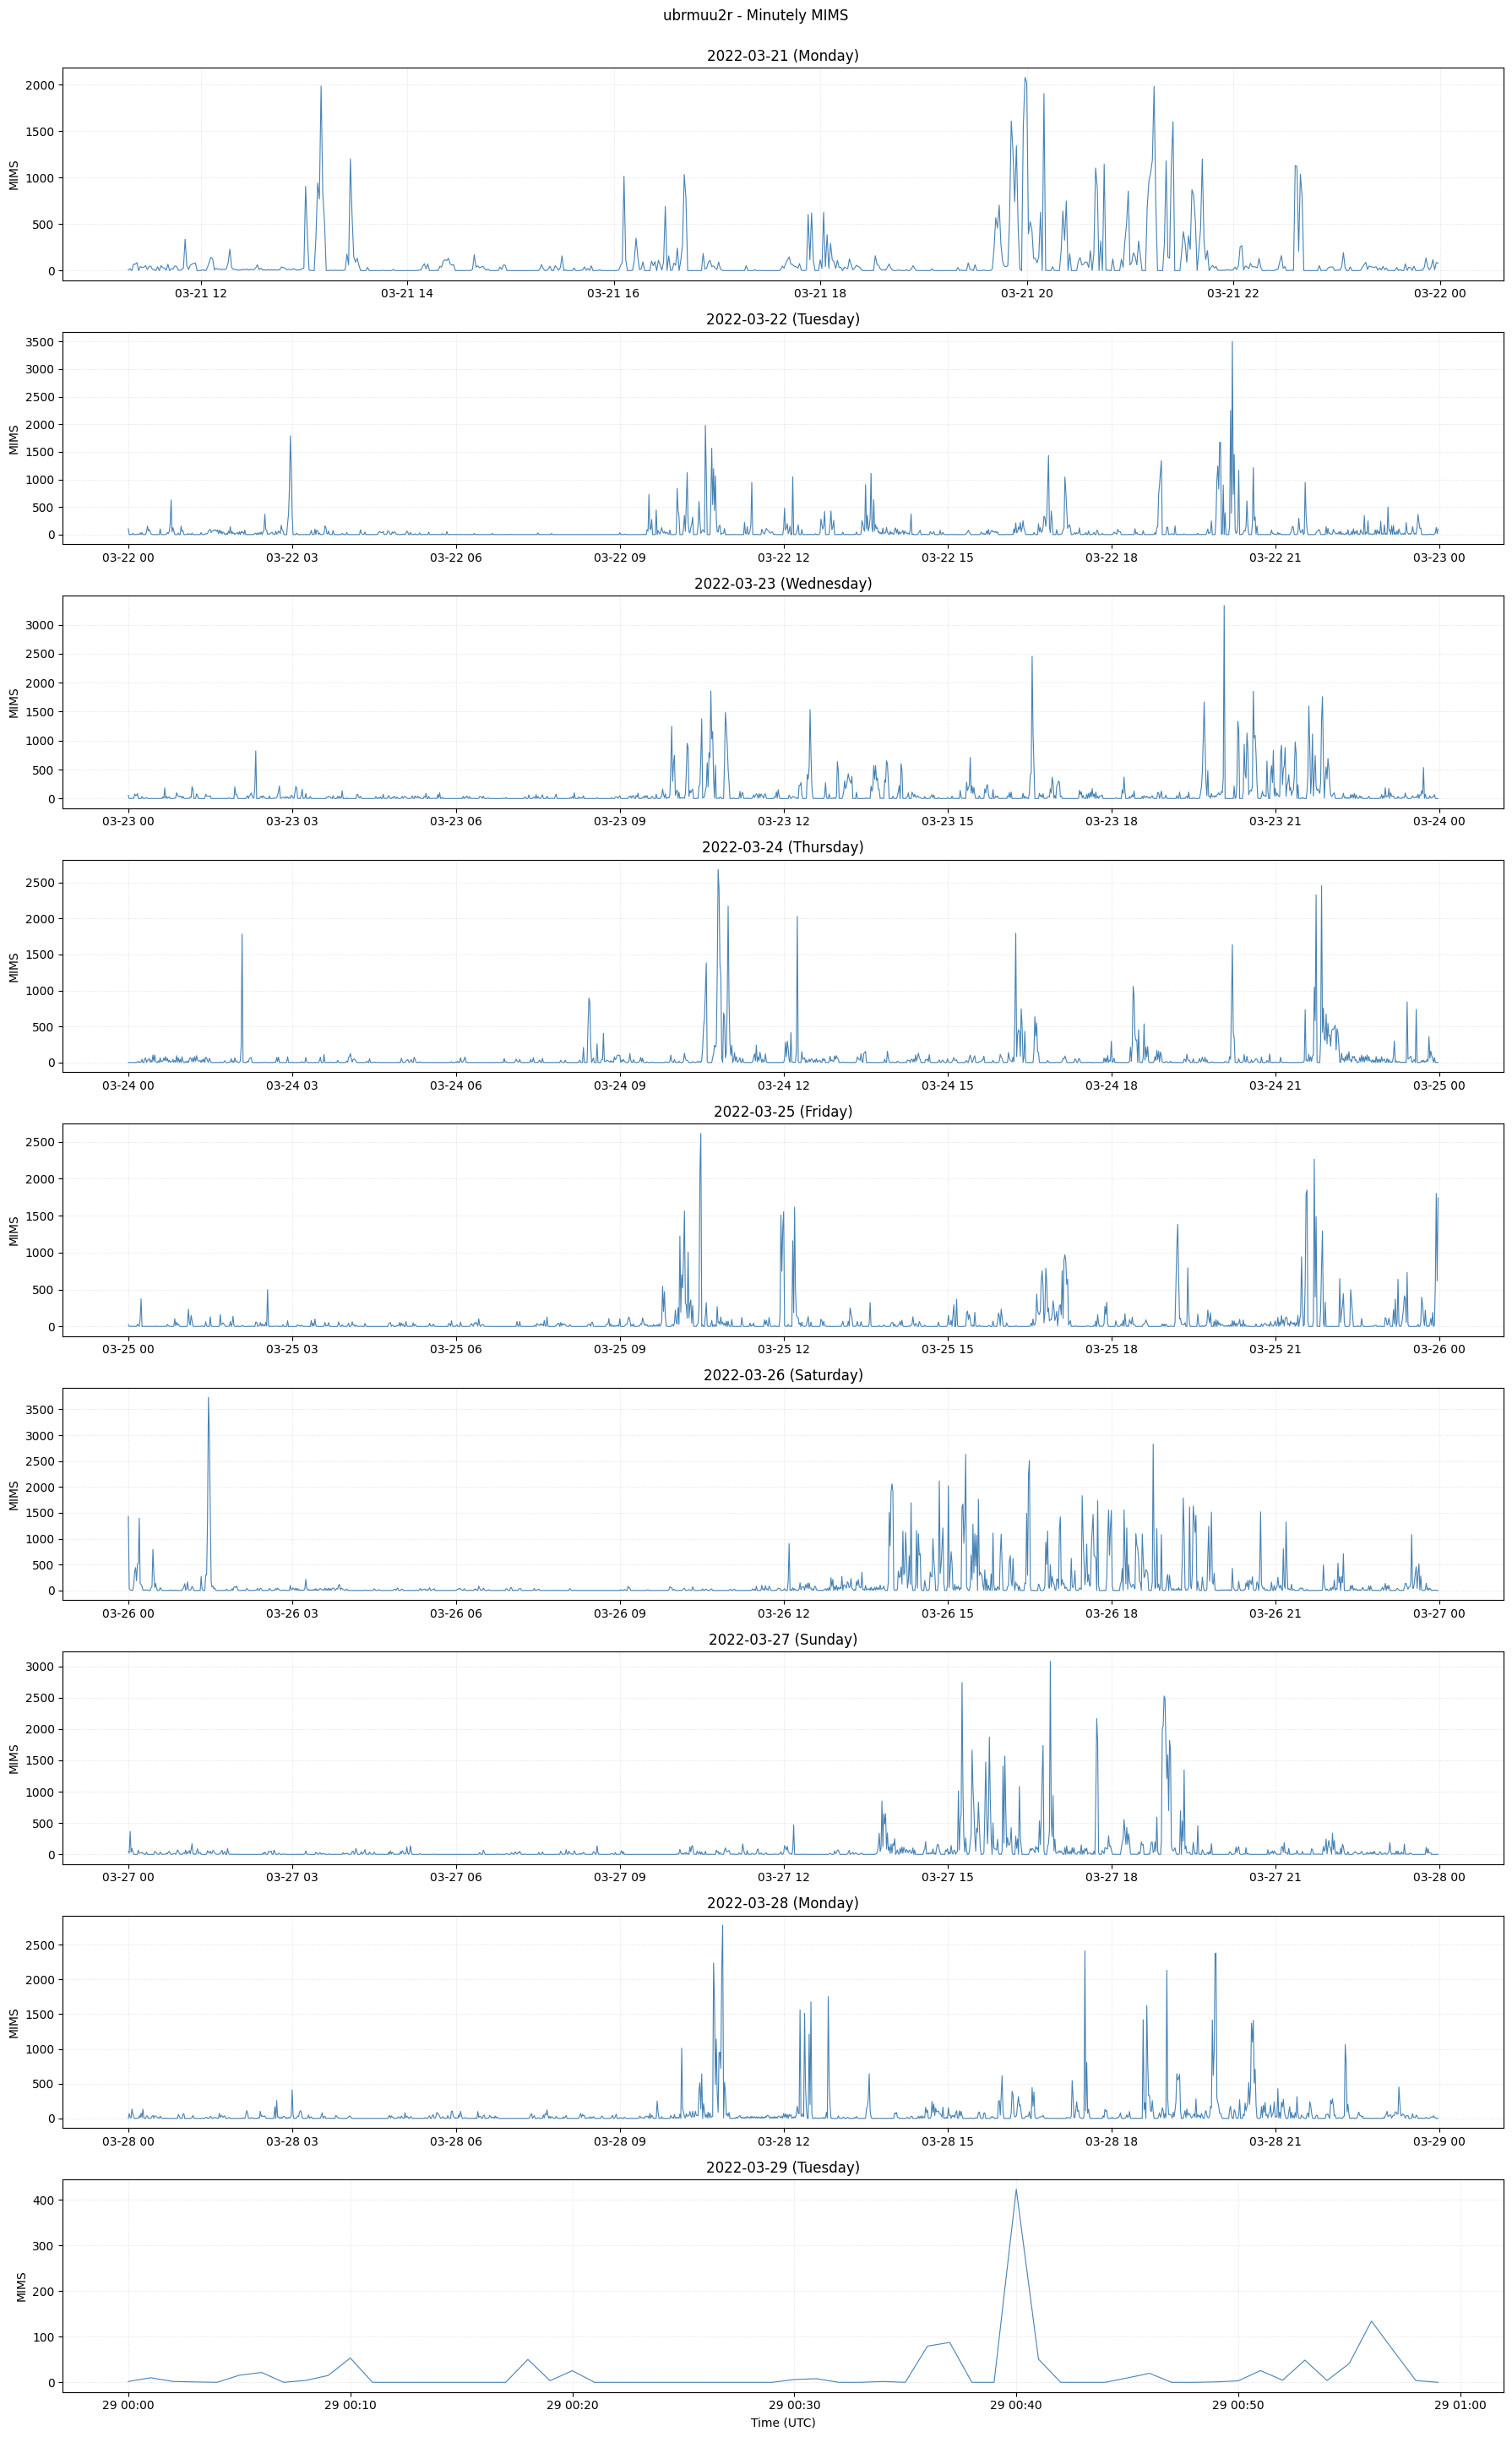


Processing xwyd72l9...
  Found 193 hourly CSV files.
  Dynamic range: -68.7362g to 69.9338g
  Aggregated 2,085,490 samples spanning 2022-03-21 00:00:00.180000+00:00 to 2022-03-29 00:59:45.064000+00:00 UTC
  Generated 11,580 minutely MIMS epochs.


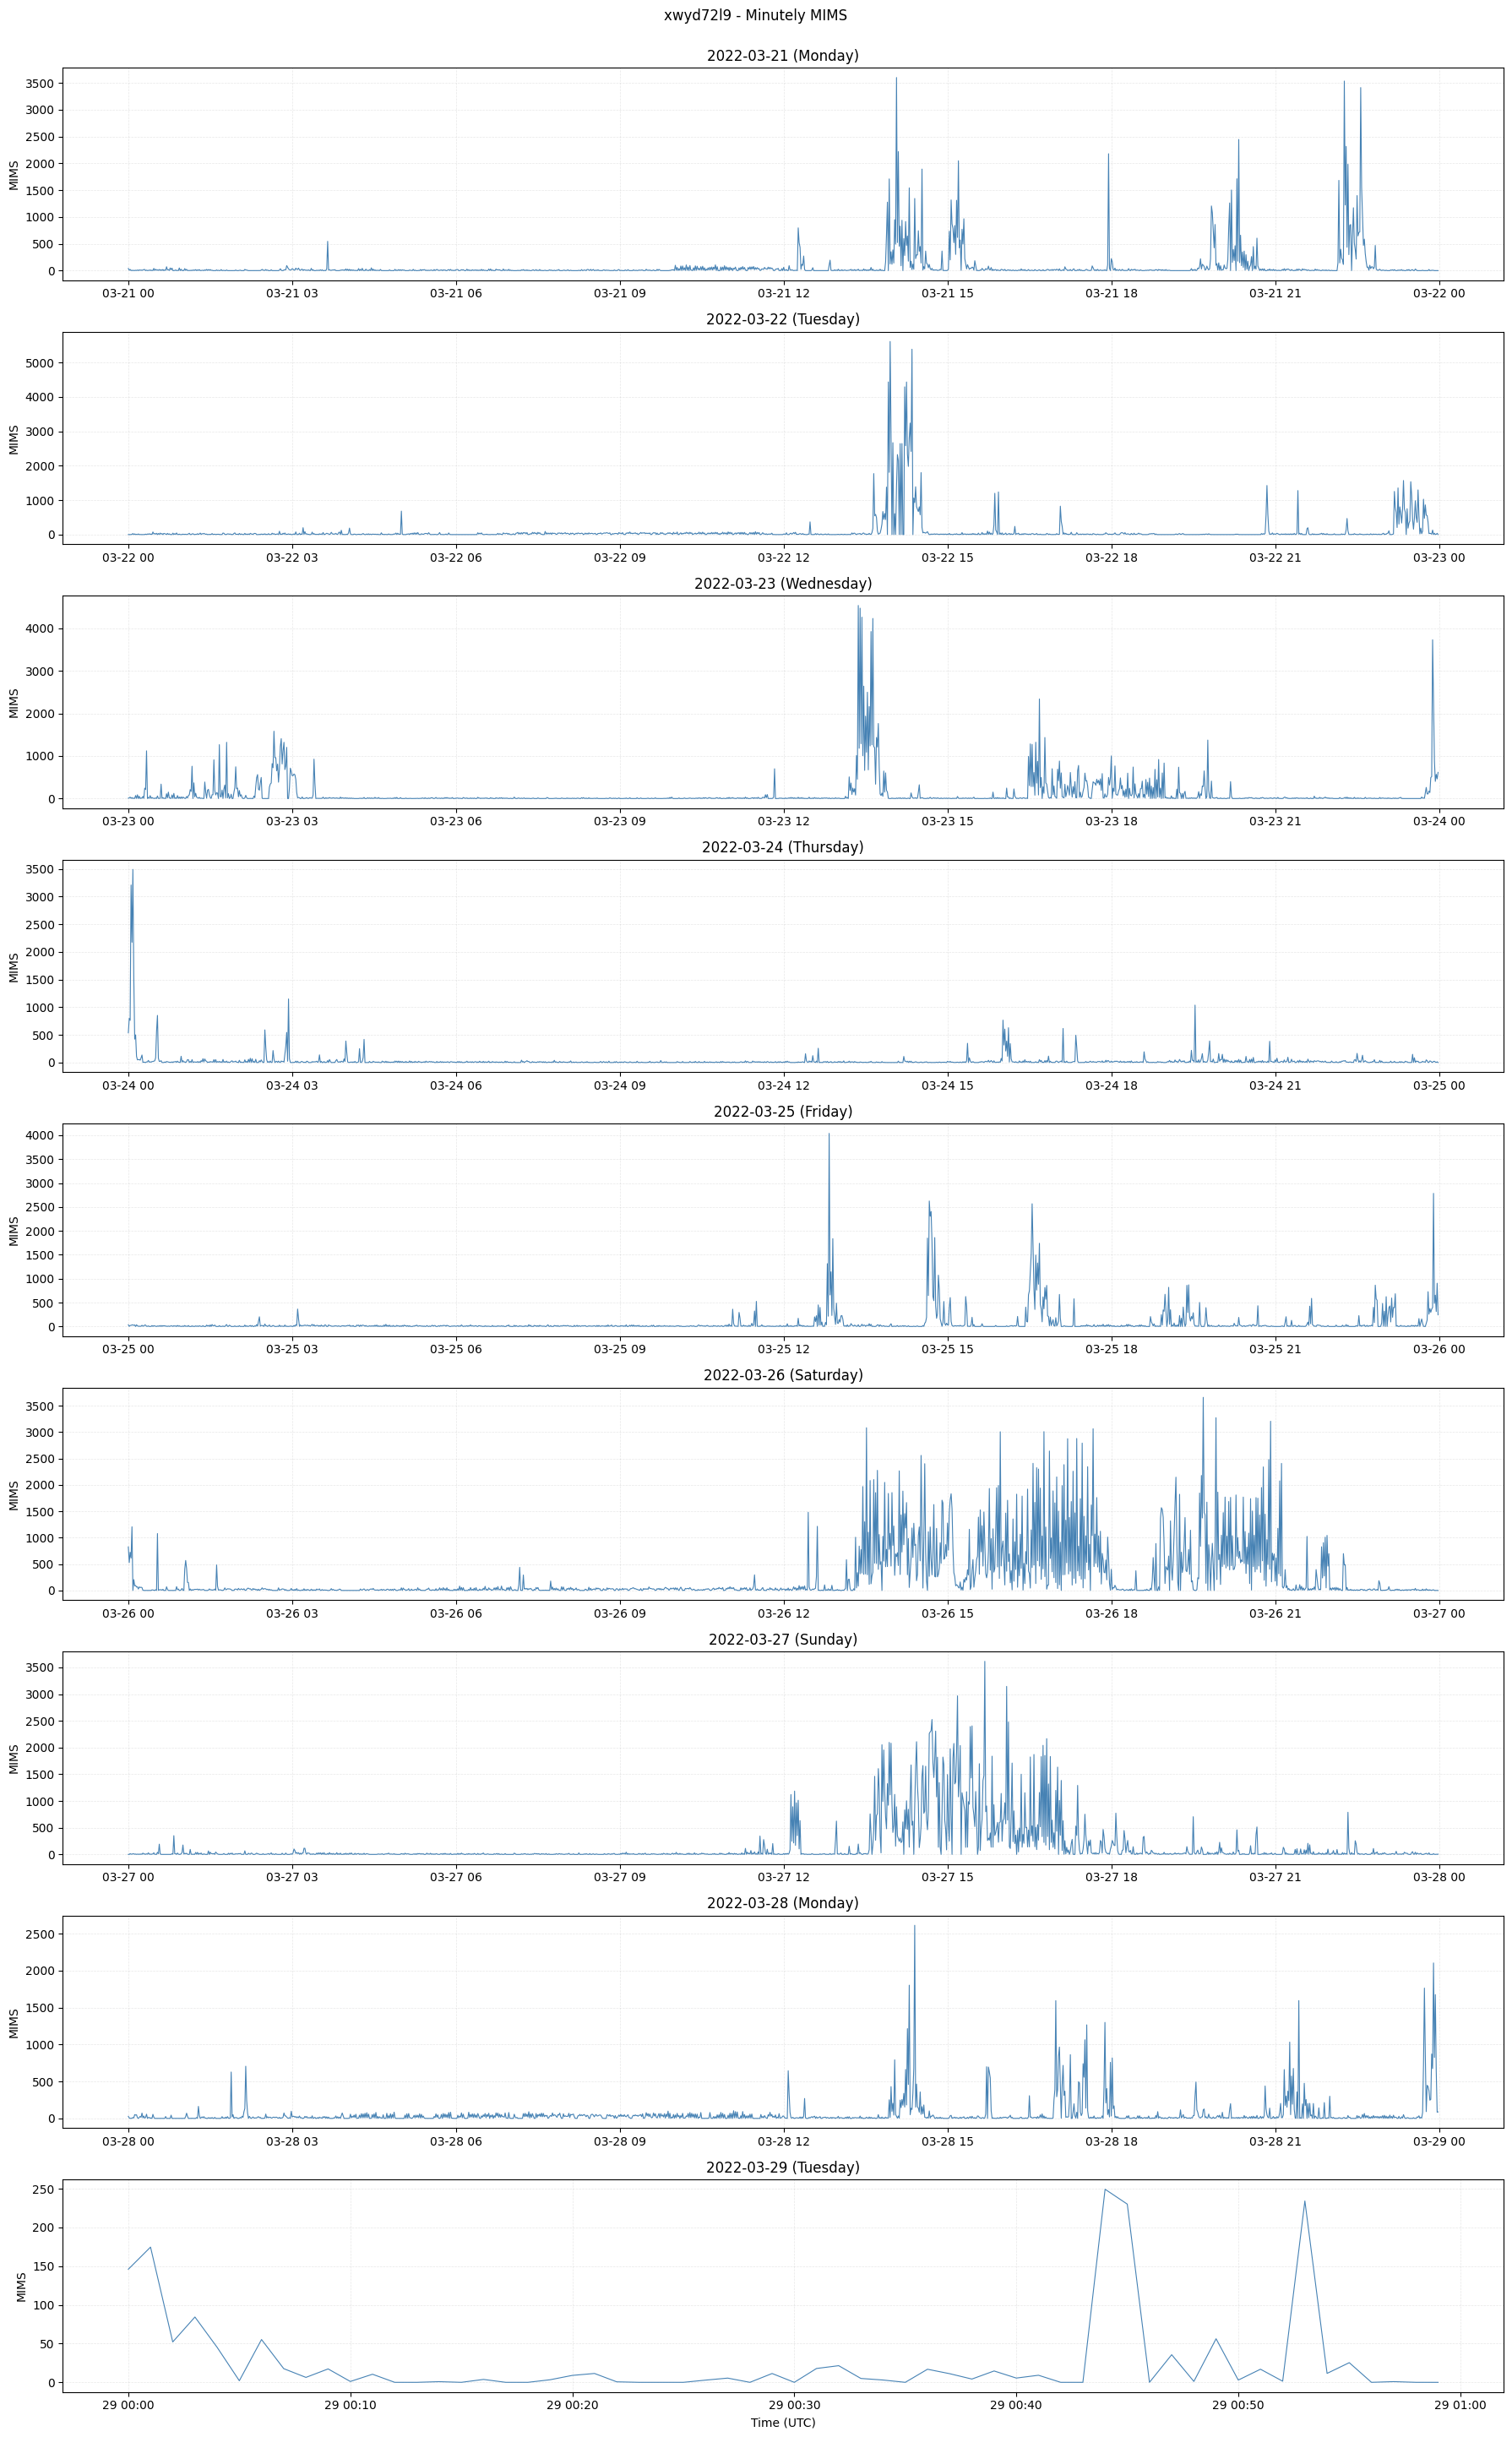


Processing zg5uqa5l...
  Found 163 hourly CSV files.
  Dynamic range: -6.0385g to 4.9419g
  Aggregated 2,307,051 samples spanning 2022-03-21 23:46:16.567000+00:00 to 2022-03-29 00:59:10.101000+00:00 UTC
  Generated 10,152 minutely MIMS epochs.


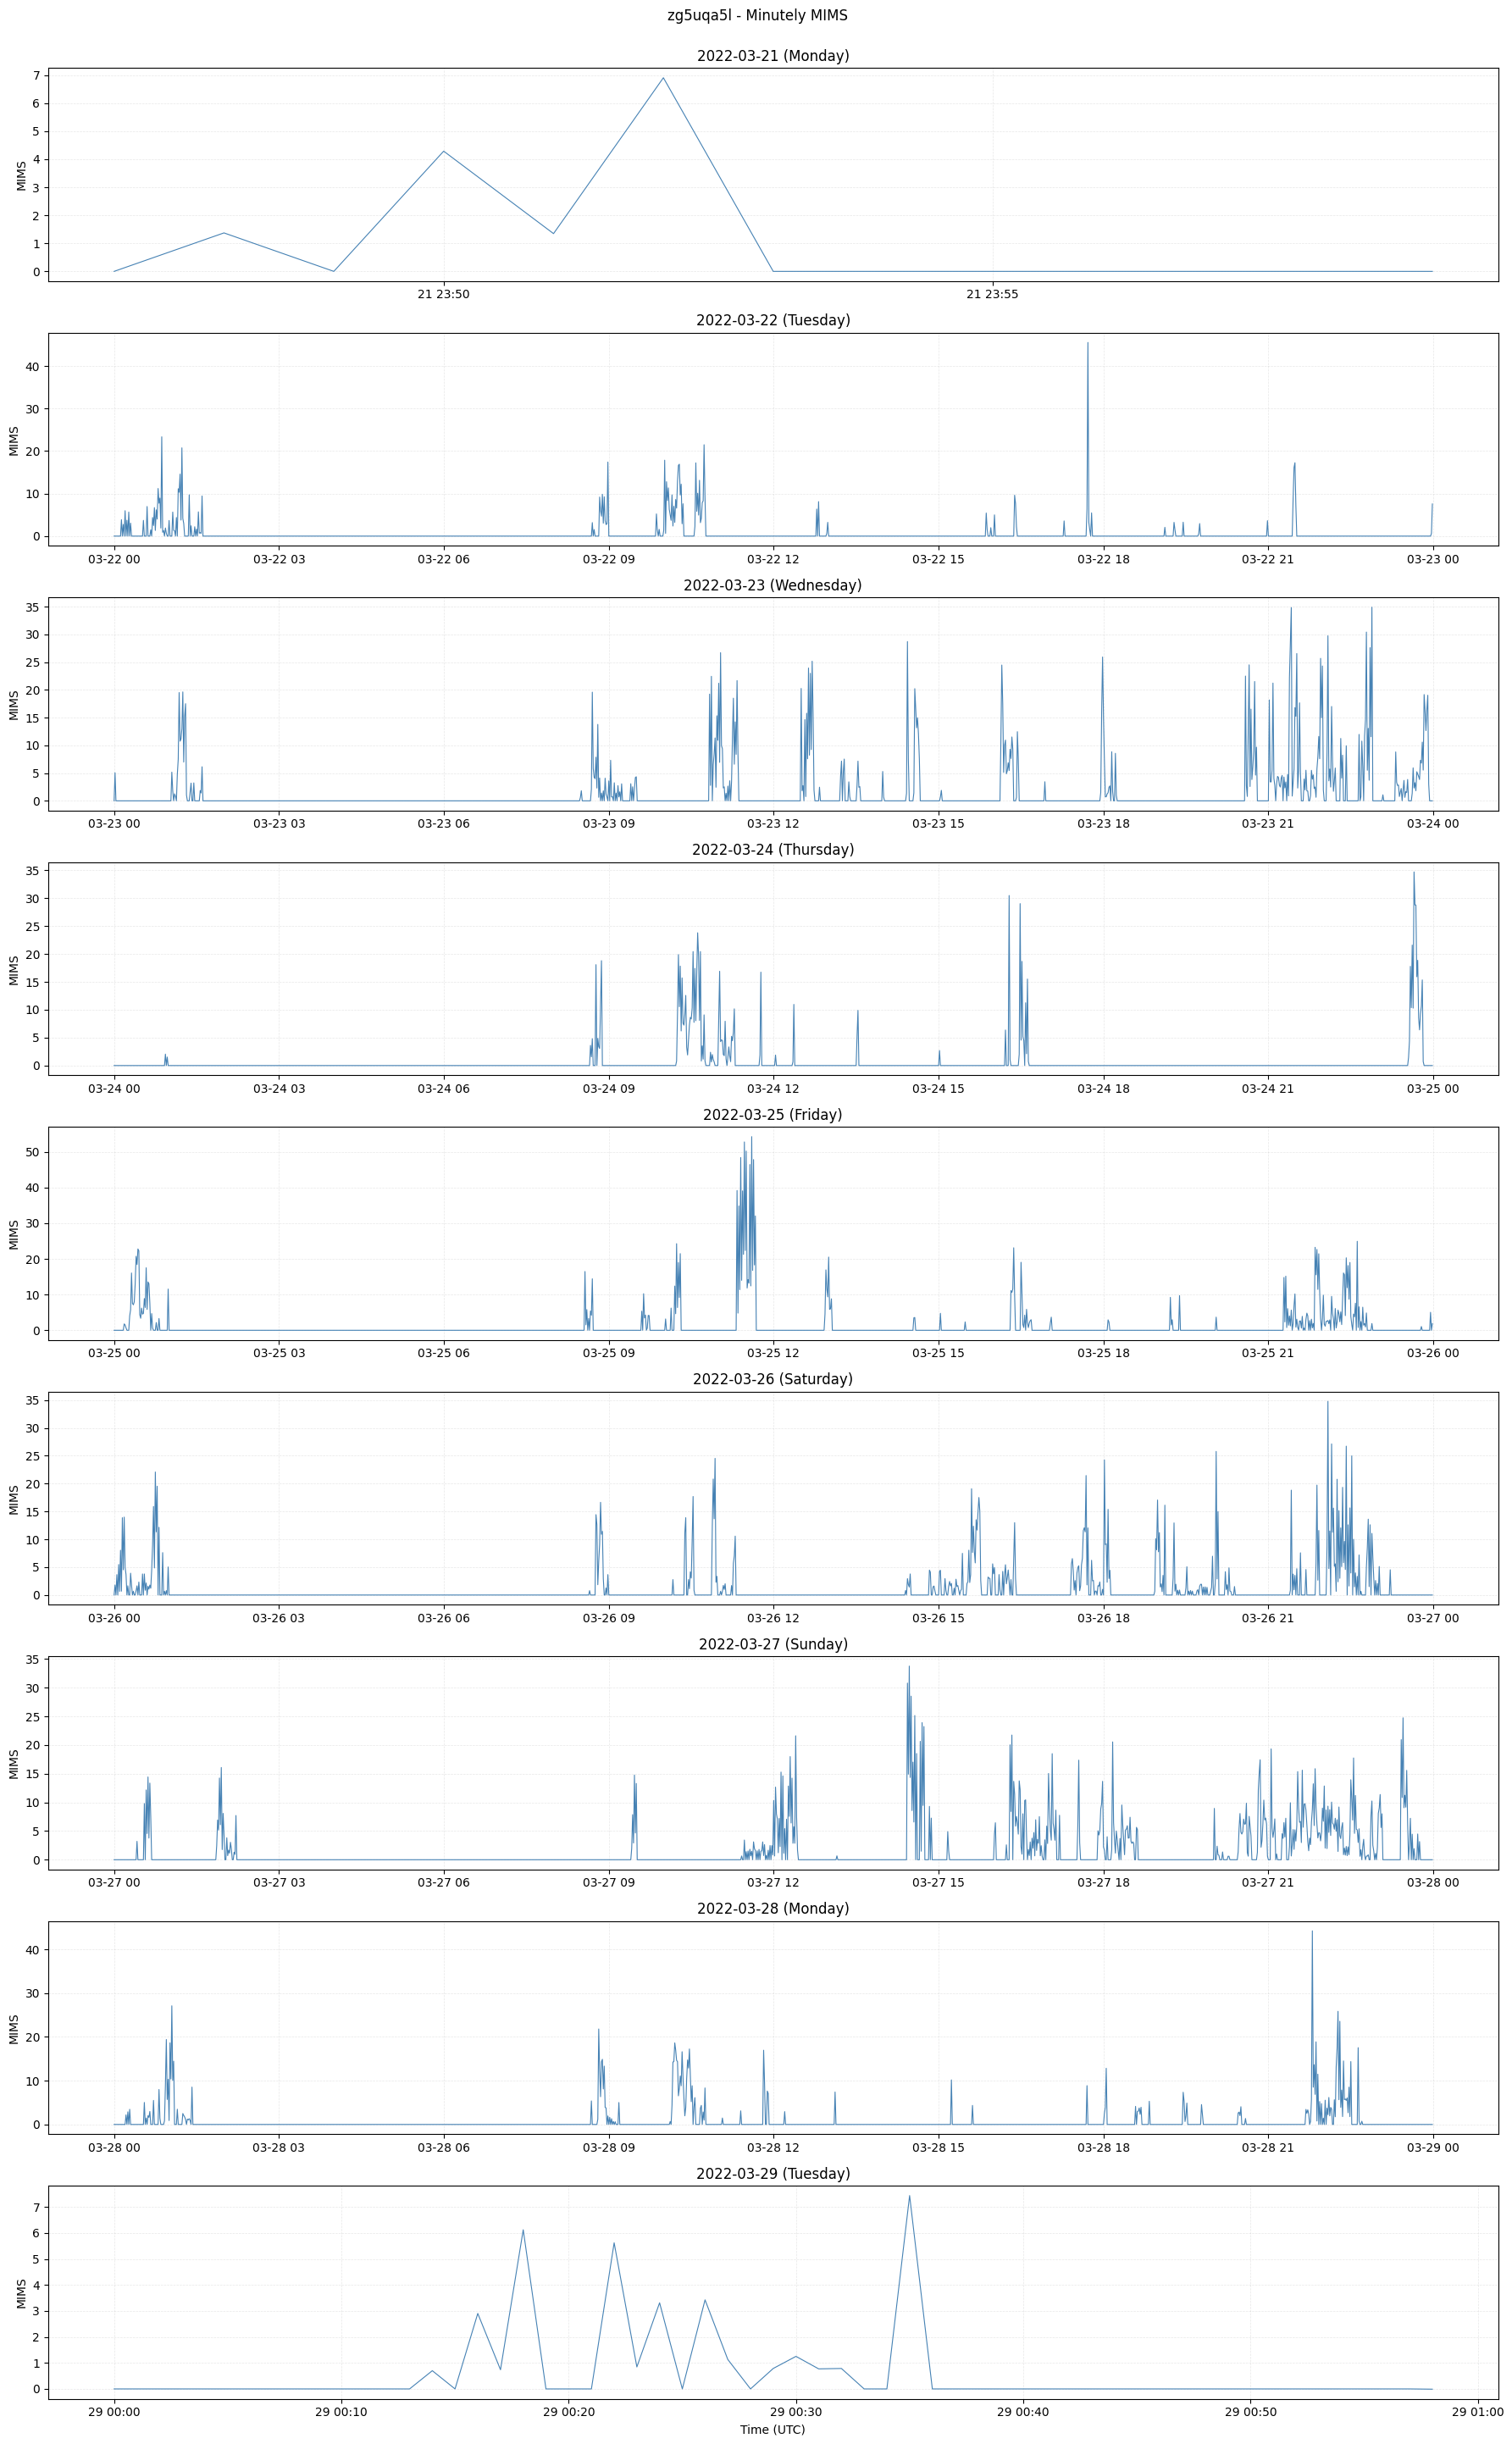

In [ ]:
subject_mims: dict[str, pd.DataFrame] = {}

for subject_id in SUBJECT_IDS:
    print(f'\nProcessing {subject_id}...')
    files = subject_csv_files(subject_id)
    print(f'  Found {len(files)} hourly CSV files.')

    dynamic_range = compute_dynamic_range(files)
    print(f'  Dynamic range: {dynamic_range[0]:.4f}g to {dynamic_range[1]:.4f}g')

    hourly_frames = [load_hourly_dataframe(fp) for fp in files]
    raw_df = (
        pd.concat(hourly_frames, ignore_index=True)
        .sort_values('timestamp')
        .drop_duplicates(subset='timestamp', keep='first')
        .reset_index(drop=True)
    )

    print(
        f'  Aggregated {len(raw_df):,} samples spanning '
        f"{raw_df['timestamp'].min()} to {raw_df['timestamp'].max()} UTC"
    )

    mims_minutely = mims_unit(
        raw_df[['timestamp', 'x', 'y', 'z']],
        epoch='1 min',
        dynamic_range=dynamic_range,
        output_mims_per_axis=False
    )

    mims_minutely.rename(columns={'MIMS_UNIT': 'mims'}, inplace=True)
    print(f'  Generated {len(mims_minutely):,} minutely MIMS epochs.')

    if mims_minutely.empty:
        print('  No MIMS epochs available to plot; skipping.')
        continue

    subject_mims[subject_id] = mims_minutely.copy()

    mims_minutely['date'] = mims_minutely['timestamp'].dt.tz_convert('UTC').dt.date
    unique_dates = sorted(mims_minutely['date'].unique())
    num_days = len(unique_dates)

    fig, axes = plt.subplots(num_days, 1, figsize=(18, 3.2 * num_days), sharex=False)
    if num_days == 1:
        axes = [axes]

    for ax, day in zip(axes, unique_dates):
        day_df = mims_minutely[mims_minutely['date'] == day]
        times = day_df['timestamp'].dt.tz_convert('UTC')
        ax.plot(times, day_df['mims'], color='steelblue', linewidth=0.8)
        weekday = pd.Timestamp(day).strftime('%A')
        ax.set_title(f'{day} ({weekday})')
        ax.set_ylabel('MIMS')
        ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)

    axes[-1].set_xlabel('Time (UTC)')
    fig.suptitle(f'{subject_id} - Minutely MIMS', y=1.0)
    plt.tight_layout()
    plt.show()


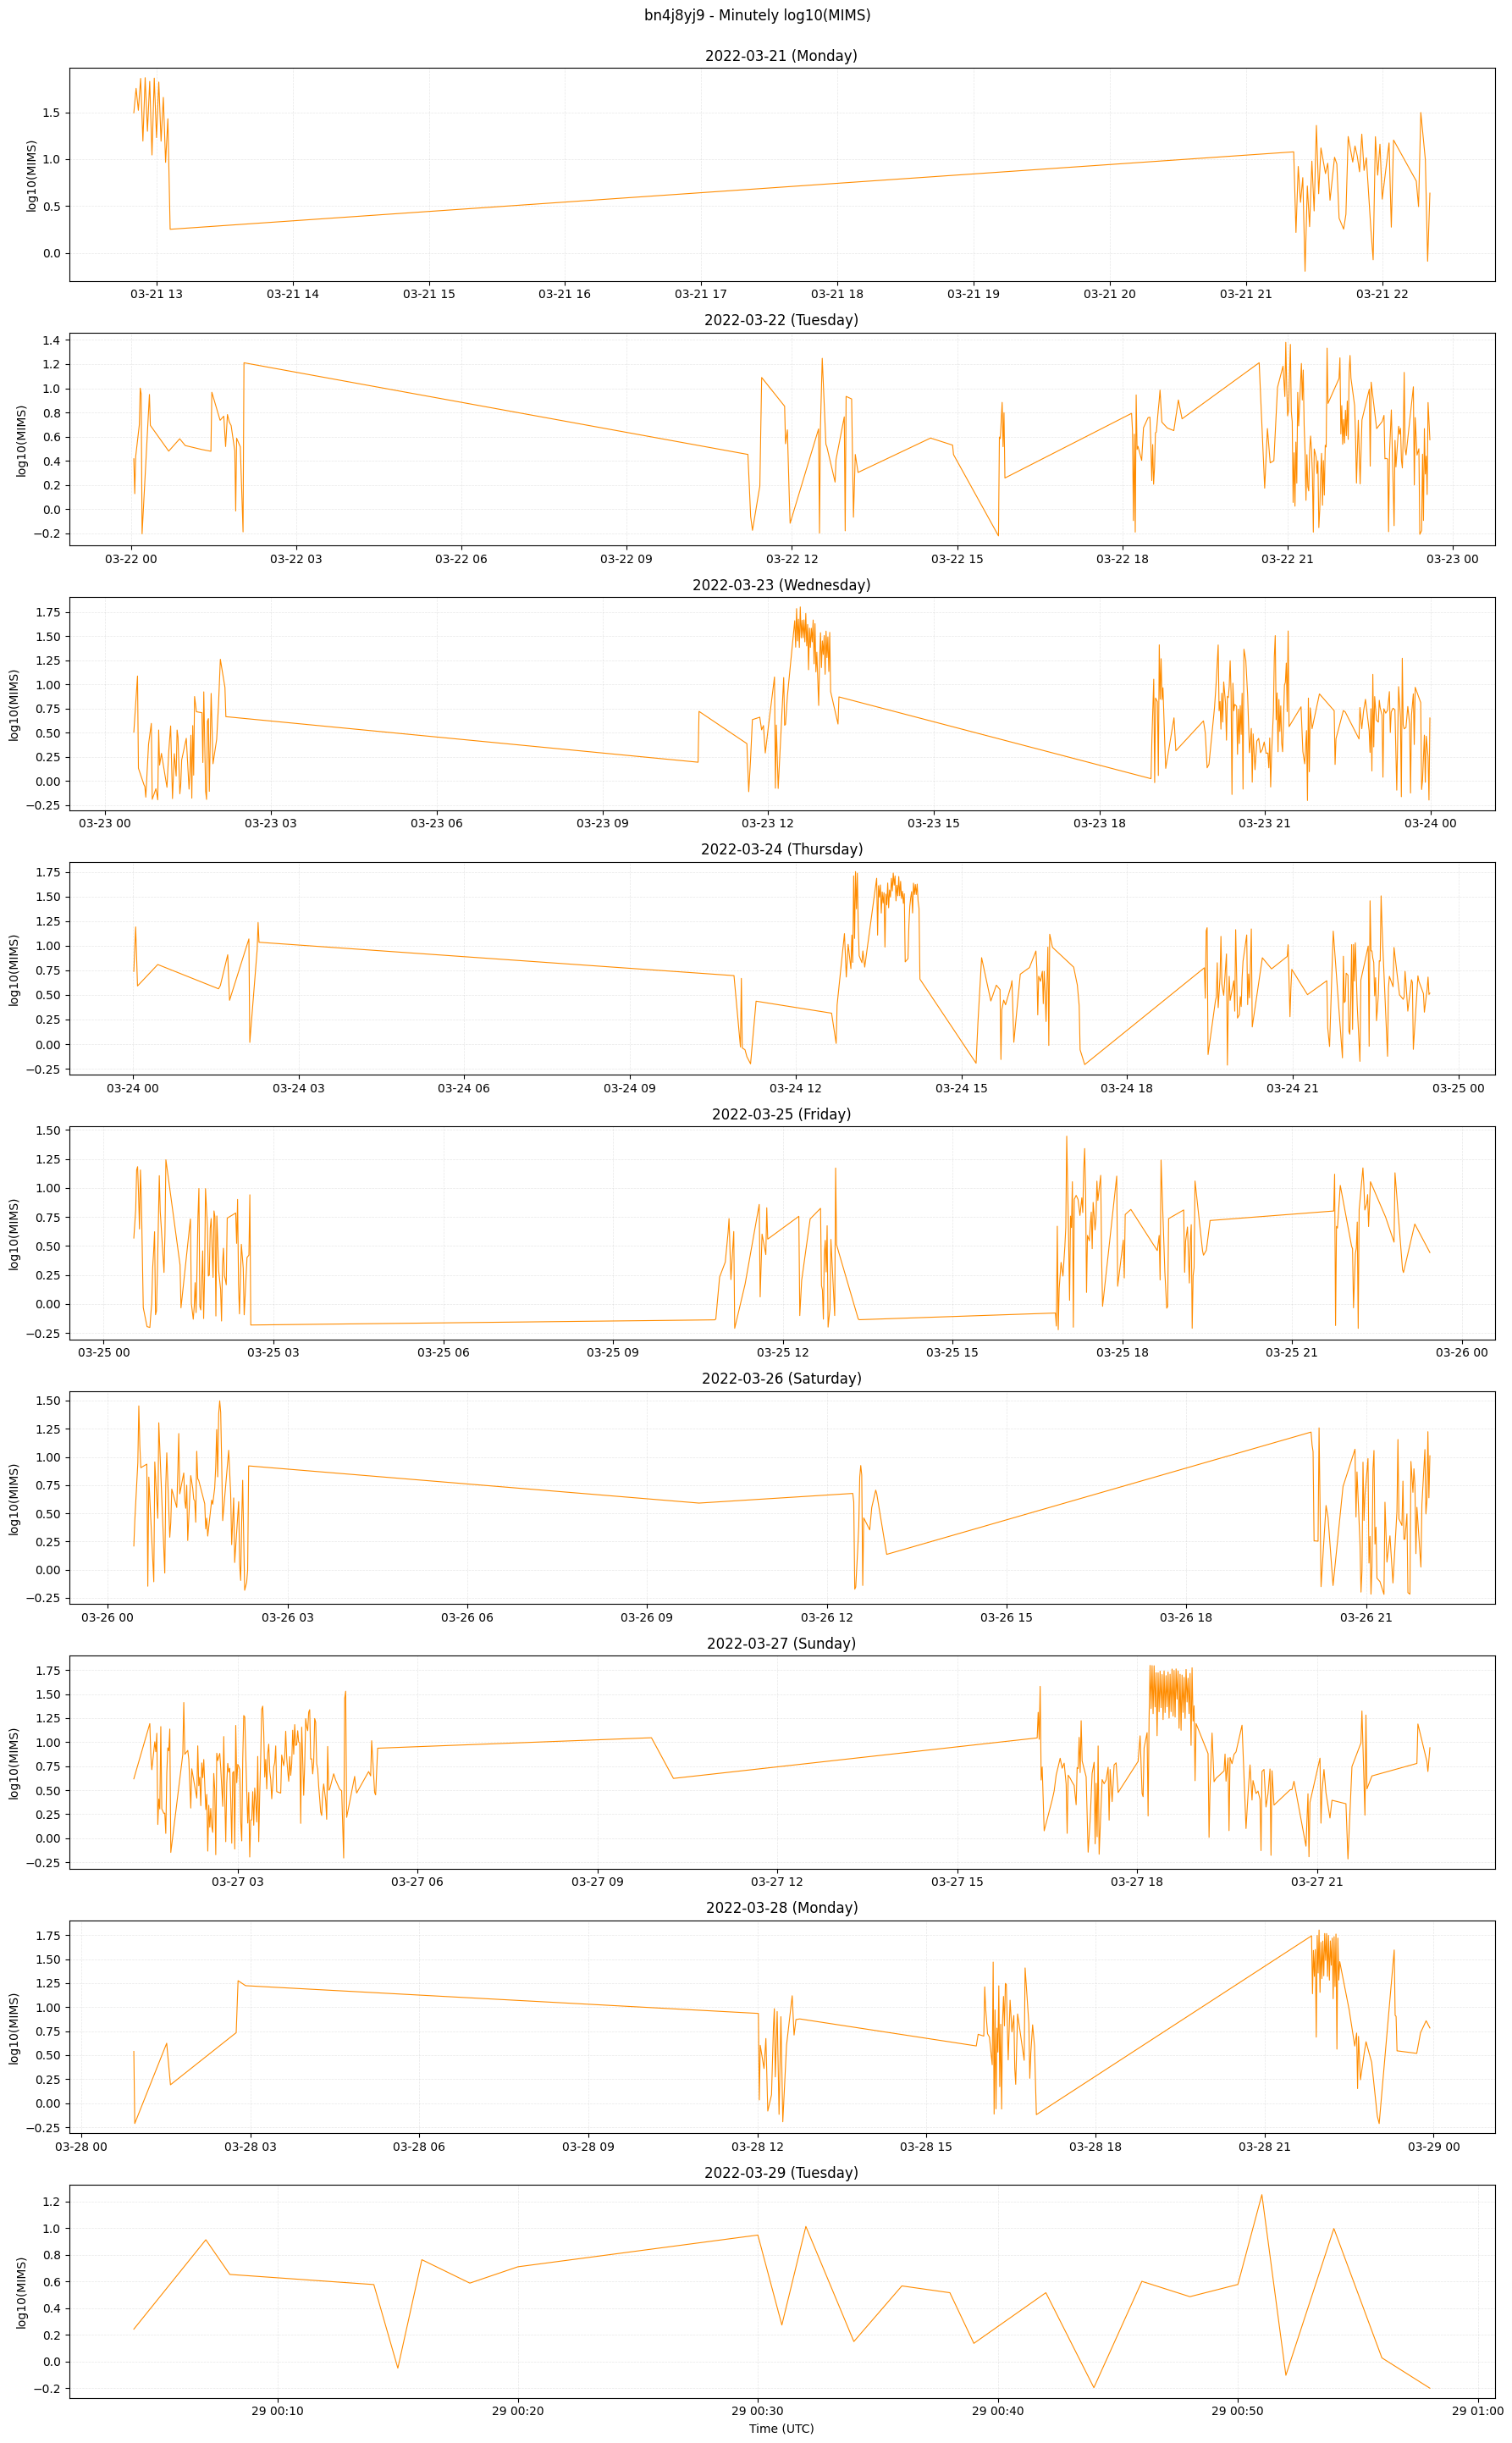

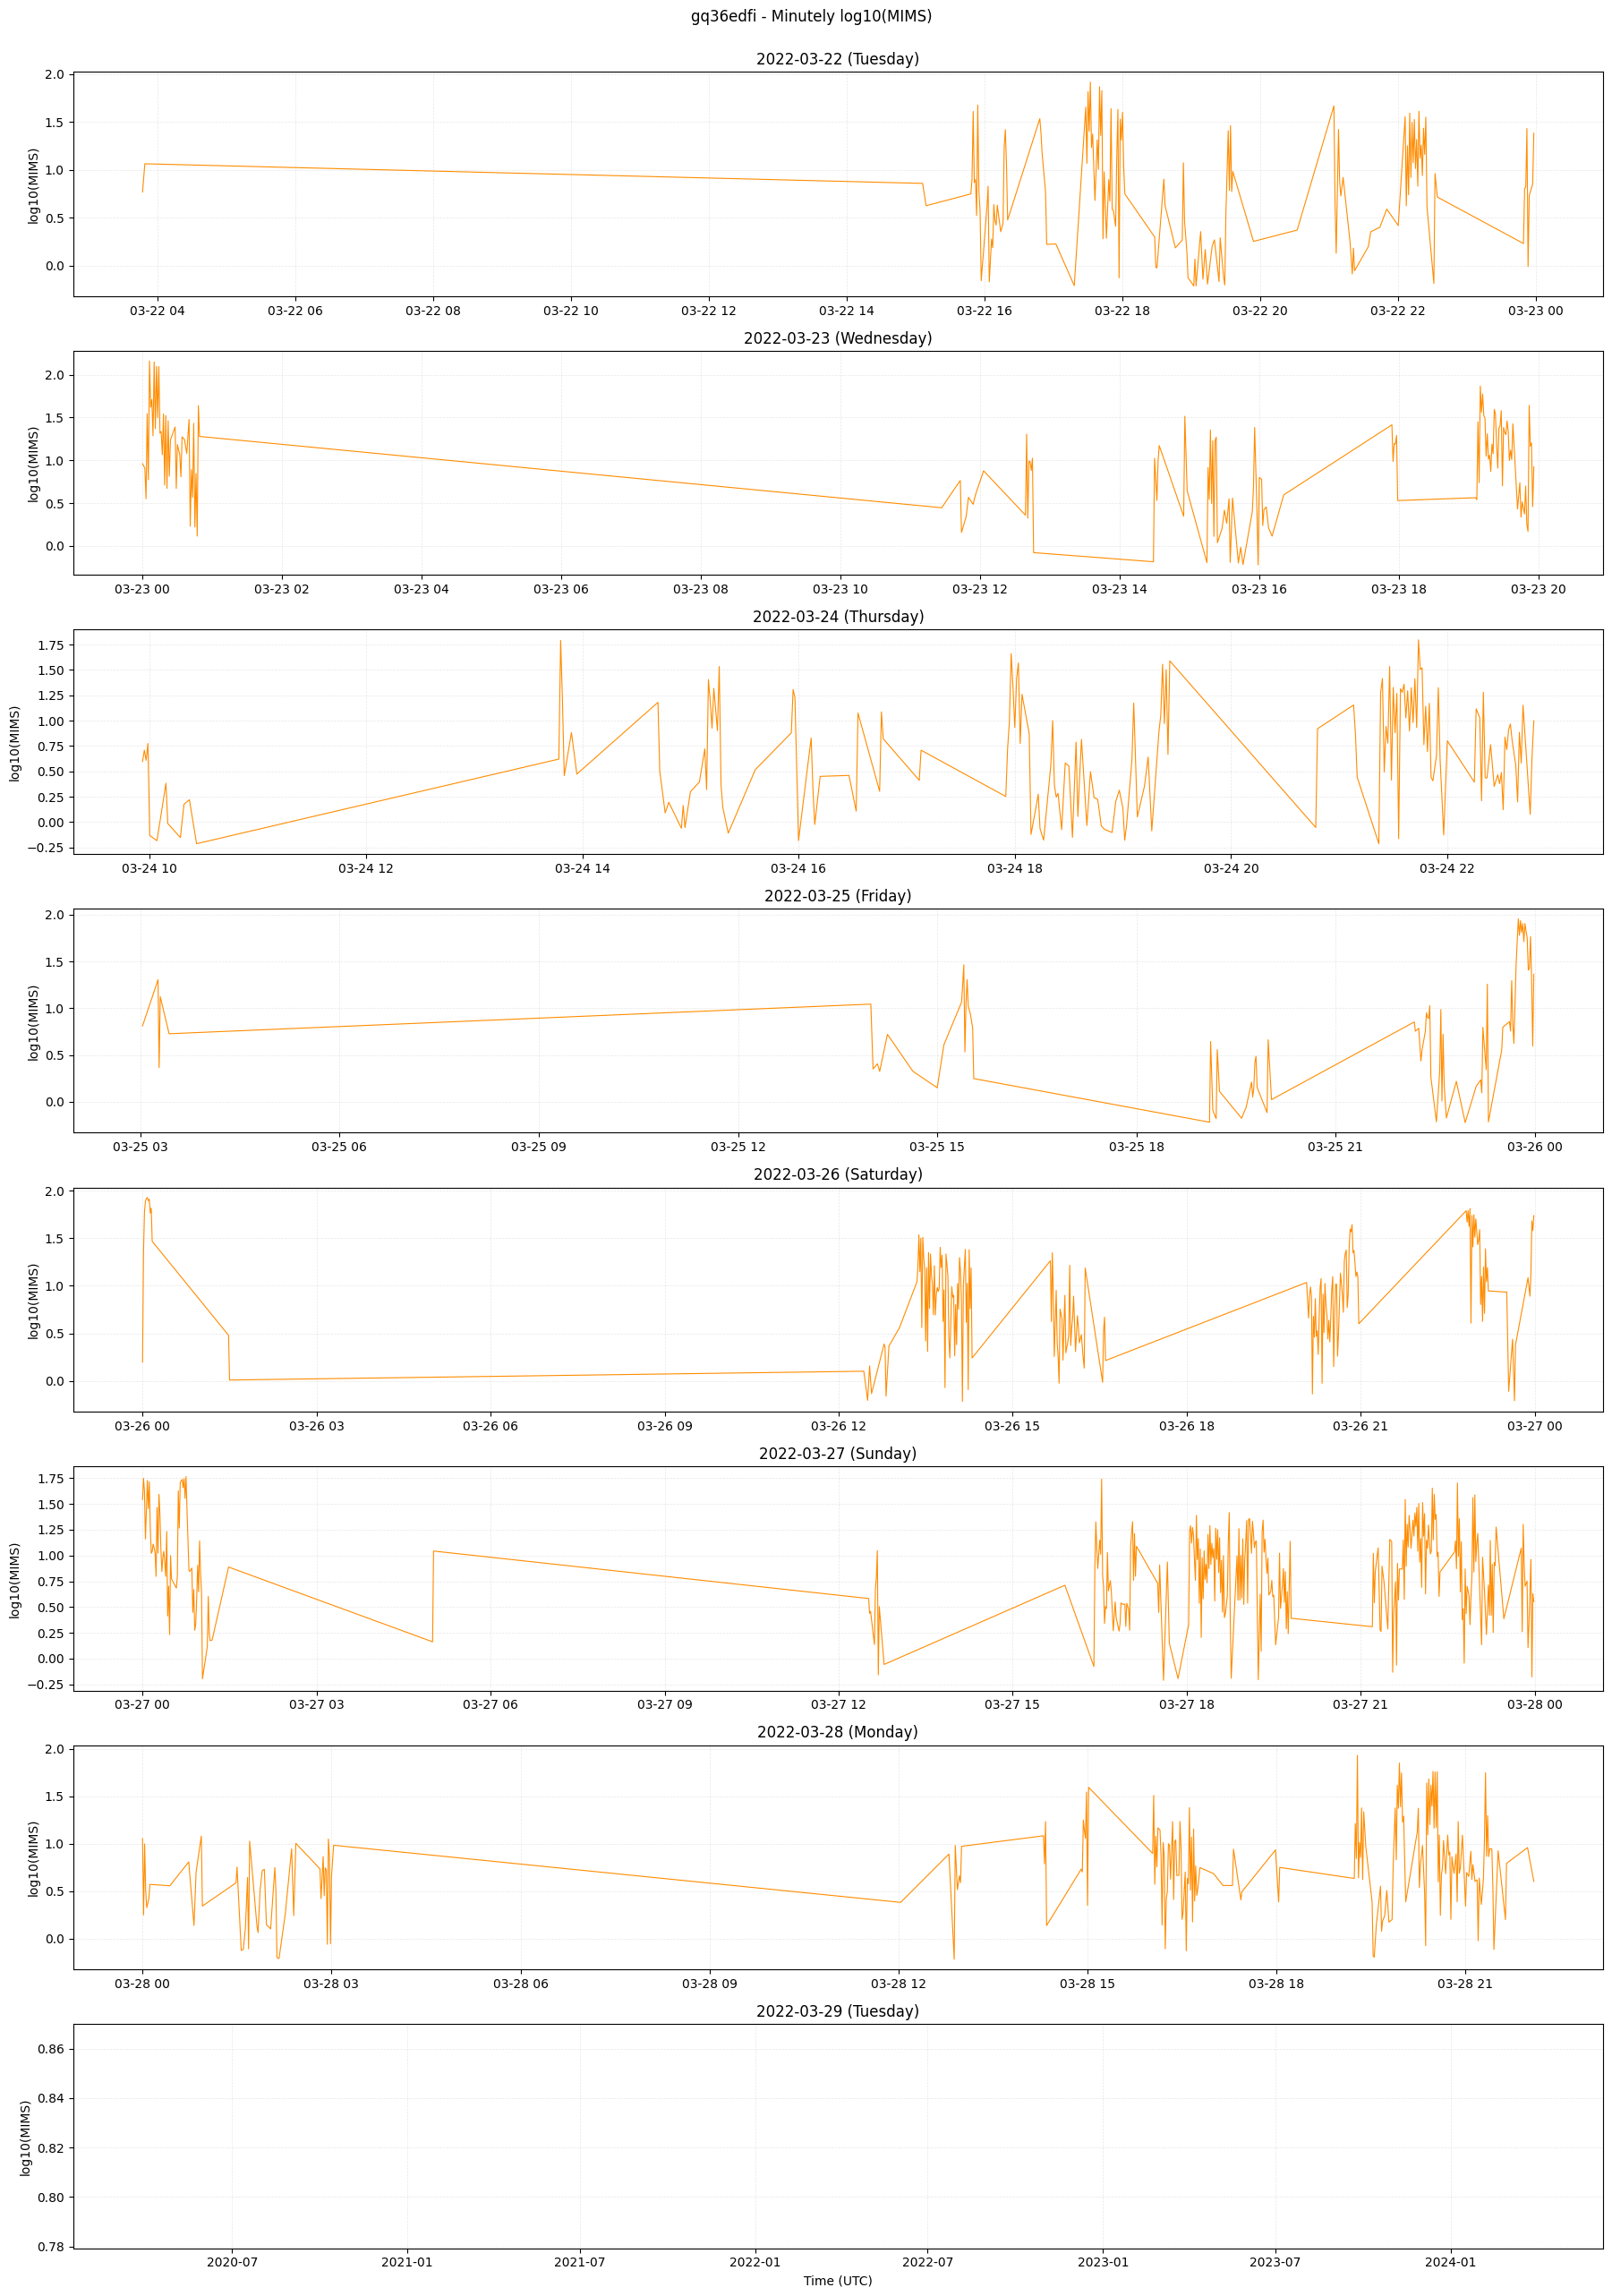

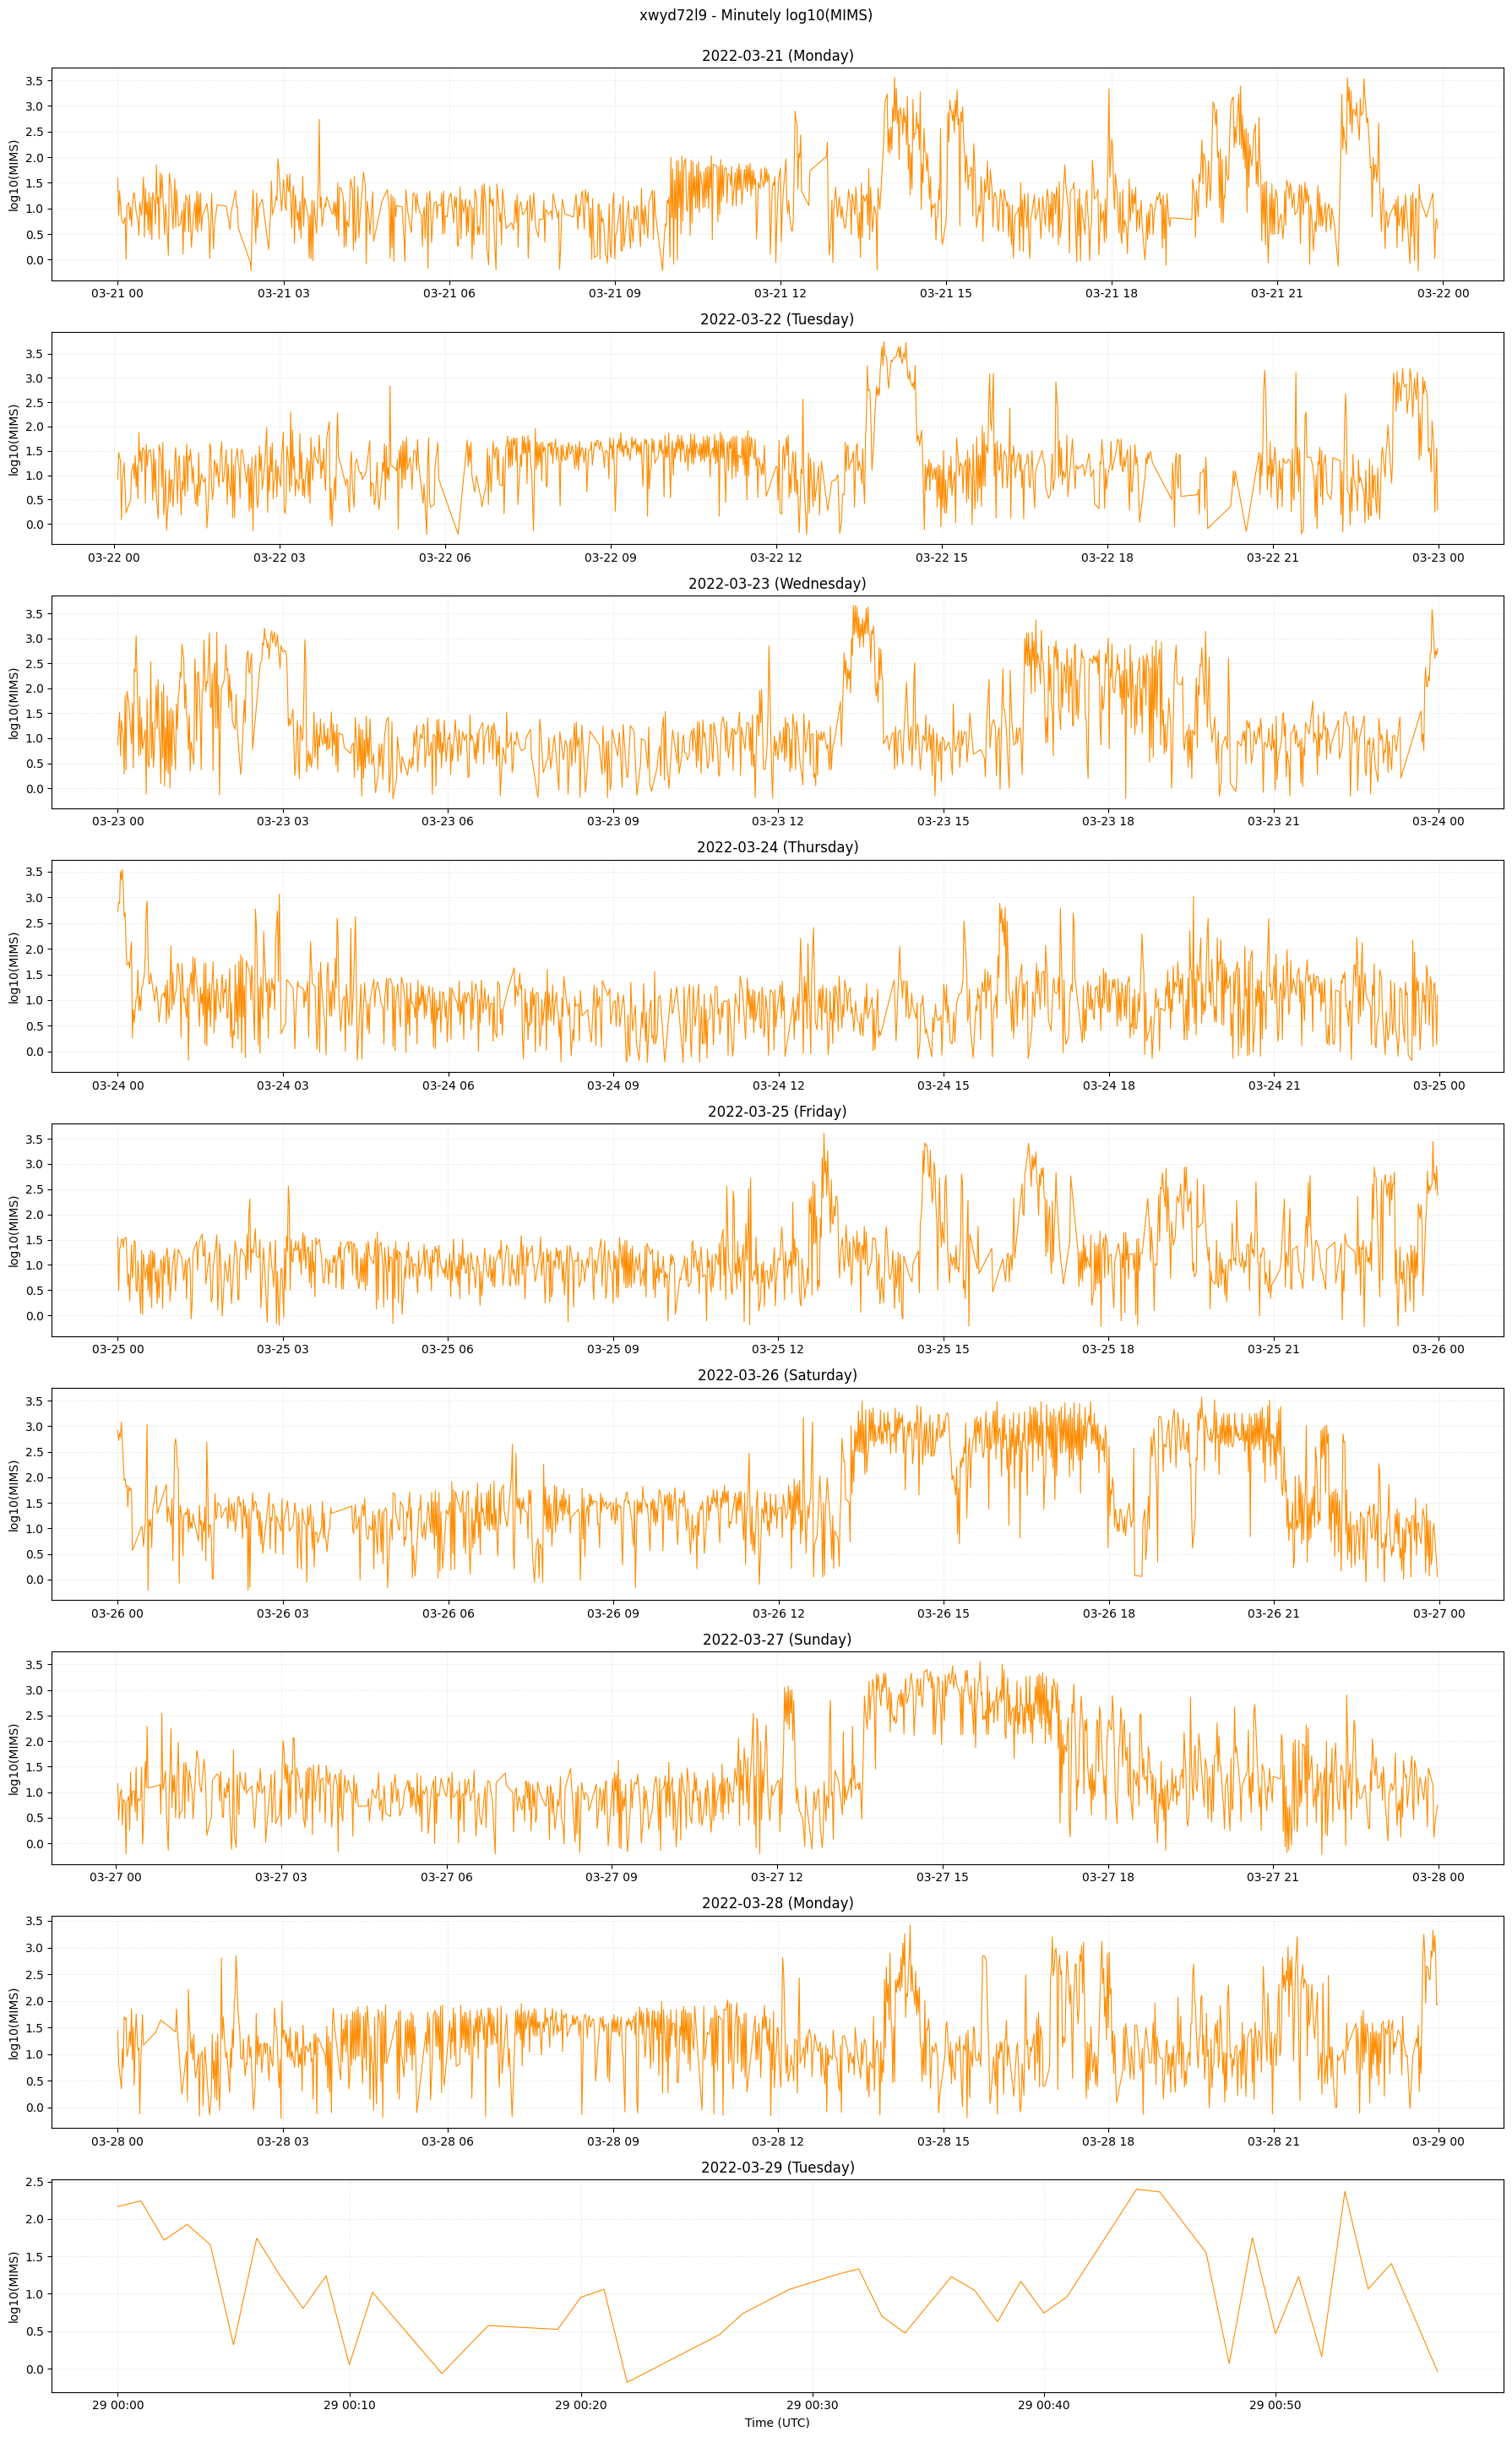

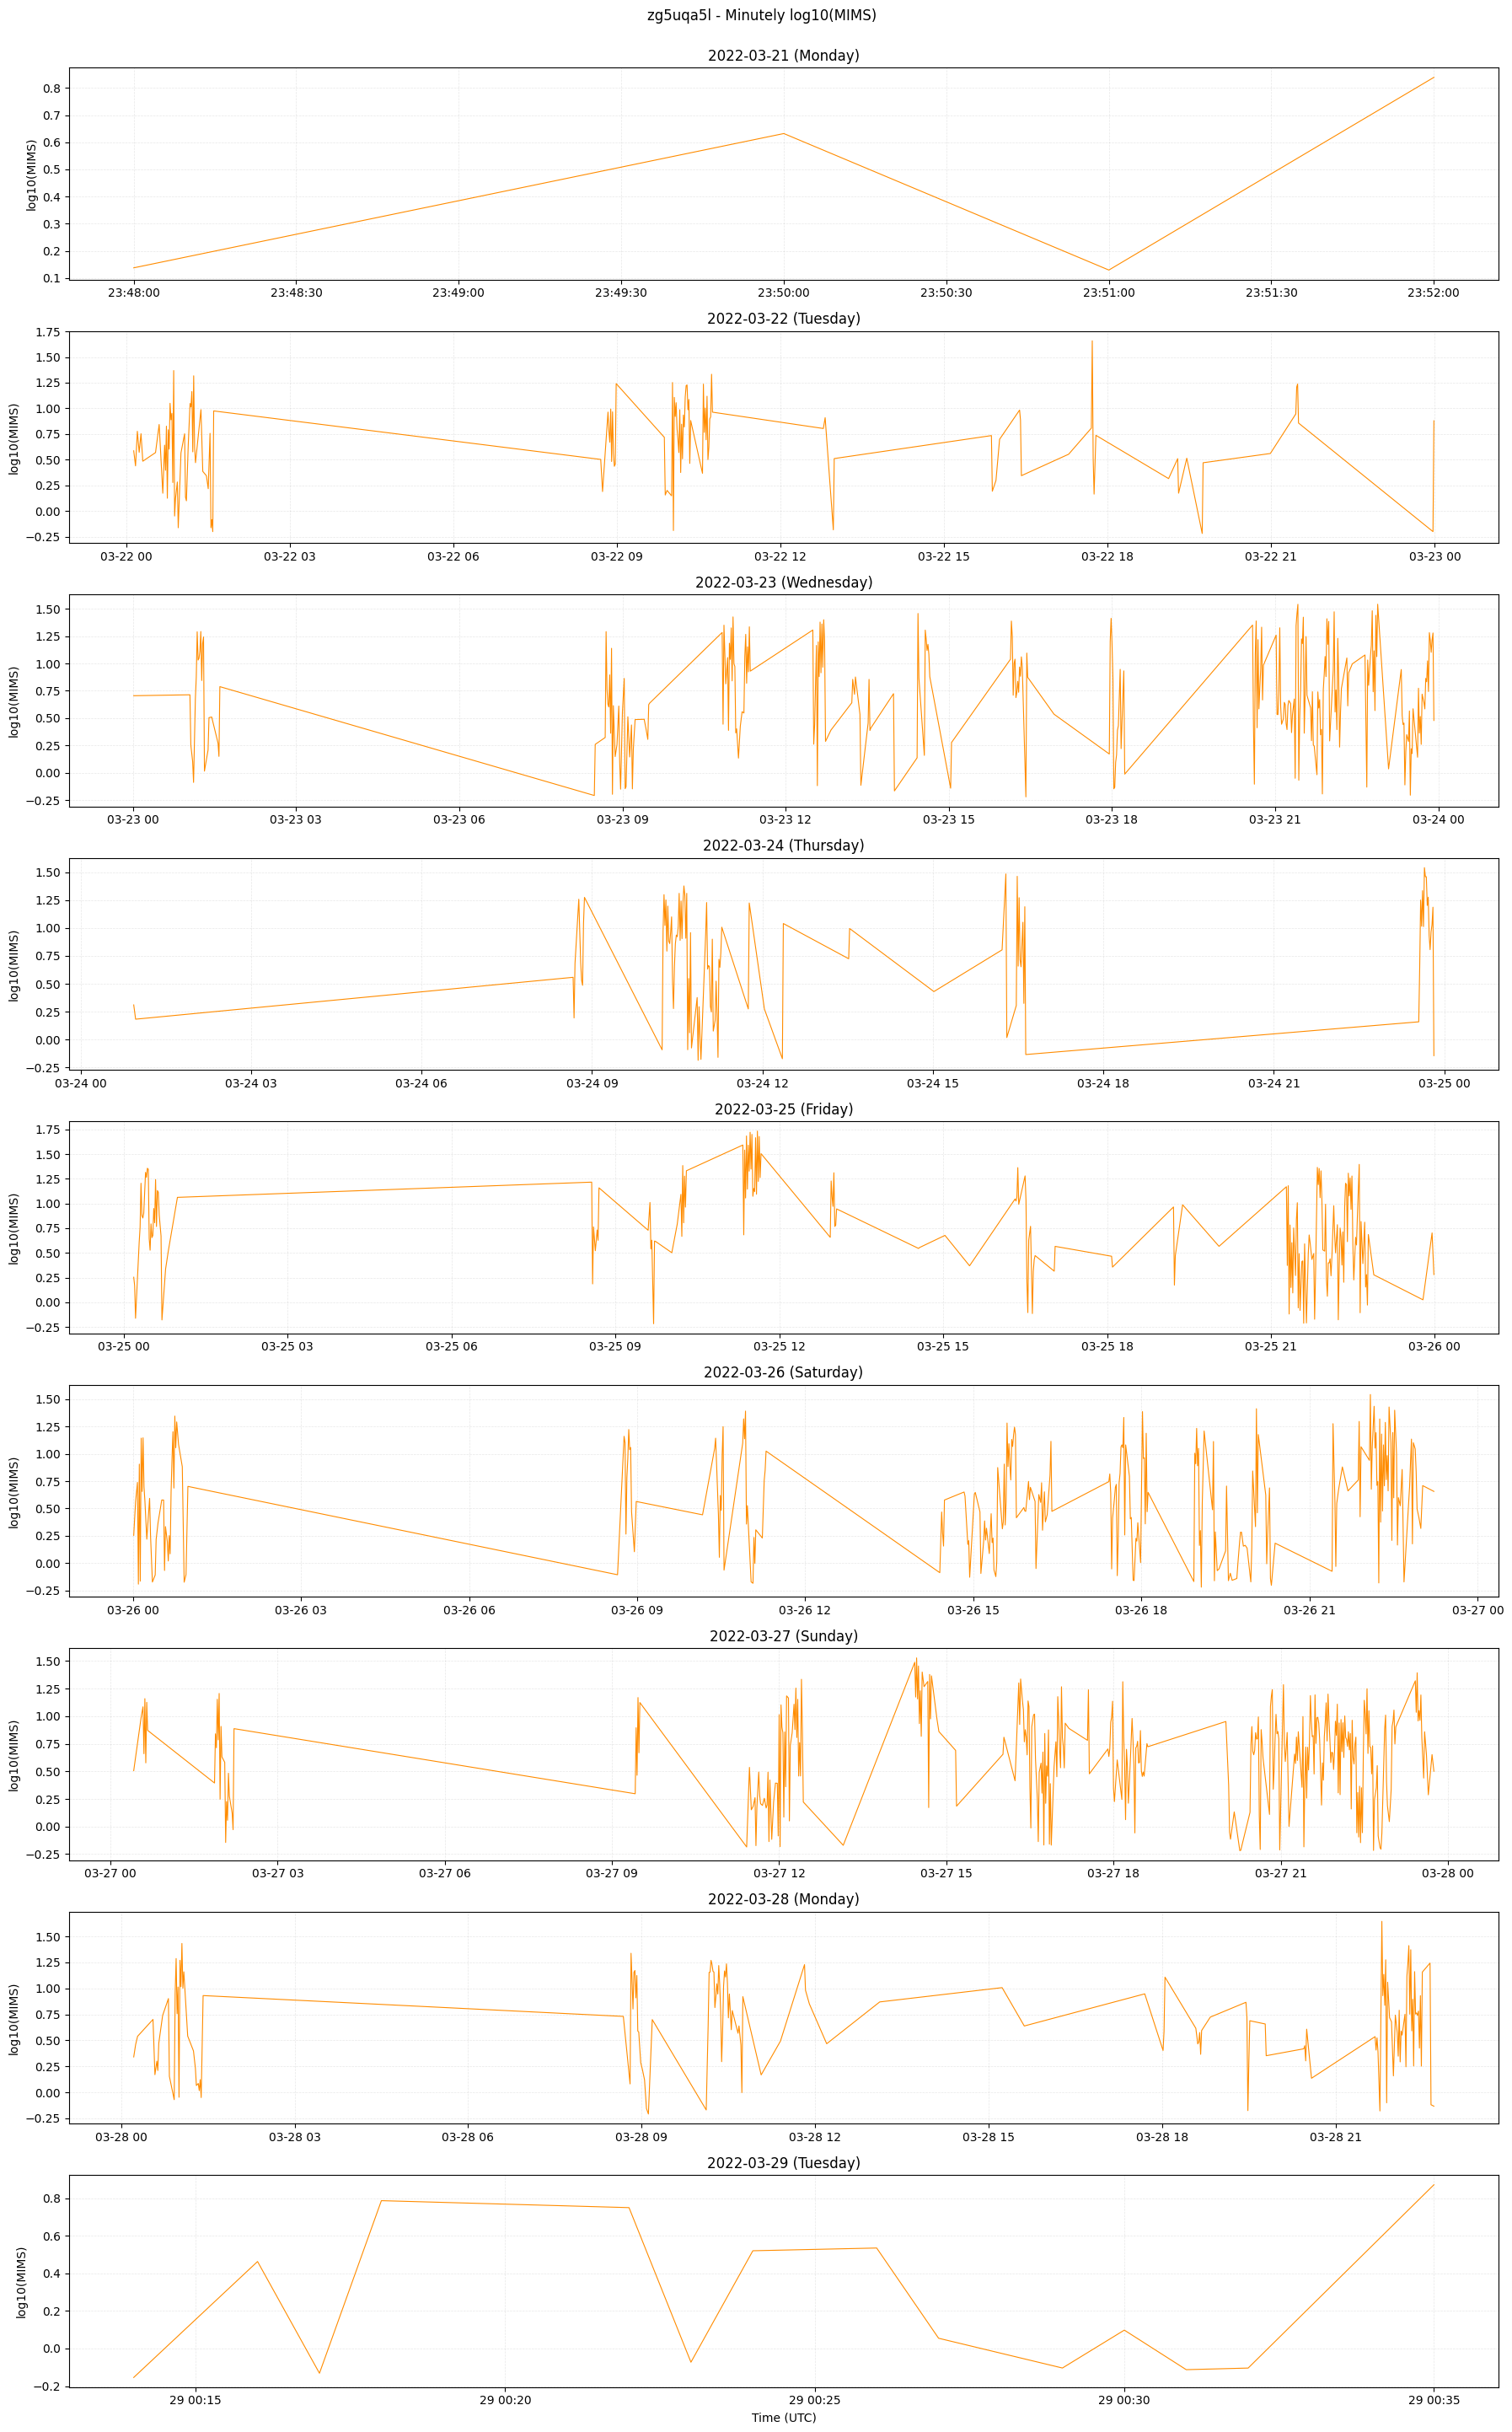

In [12]:
for subject_id, mims_df in subject_mims.items():
    positive_mask = mims_df['mims'] > 0
    if not positive_mask.any():
        print(f'No positive MIMS values for {subject_id}; skipping log plot.')
        continue

    log_df = mims_df.loc[positive_mask].copy()
    log_df['date'] = log_df['timestamp'].dt.tz_convert('UTC').dt.date
    log_df['log_mims'] = np.log10(log_df['mims'].clip(lower=1e-6))

    unique_dates = sorted(log_df['date'].unique())
    num_days = len(unique_dates)

    fig, axes = plt.subplots(num_days, 1, figsize=(18, 3.2 * num_days), sharex=False)
    if num_days == 1:
        axes = [axes]

    for ax, day in zip(axes, unique_dates):
        day_df = log_df[log_df['date'] == day]
        times = day_df['timestamp'].dt.tz_convert('UTC')
        ax.plot(times, day_df['log_mims'], color='darkorange', linewidth=0.8)
        weekday = pd.Timestamp(day).strftime('%A')
        ax.set_title(f'{day} ({weekday})')
        ax.set_ylabel('log10(MIMS)')
        ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)

    axes[-1].set_xlabel('Time (UTC)')
    fig.suptitle(f'{subject_id} - Minutely log10(MIMS)', y=1.0)
    plt.tight_layout()
    plt.show()
